# Exercise 3: Extracting image features

## 1. Install dependencies, if needed

Run the commands below to install the dependencies

In [1]:
import sys
!{sys.executable} -m pip install pillow matplotlib scikit-image scikit-learn

## 2. Read image and crop region
- Download the image from [here](https://drive.google.com/file/d/1hr6WrcB-b8PManBNfbEHYlh_YmRgNboz/view?usp=sharing). The zip file contains one normalized image with 3 bands (near infrared, red and green). Read the image using the function ***imread*** of the ***skimage*** library, and visualize it using ***matplotlib***
- Use the provided bounding boxes to crop a region that contains a building
- Visualize the patch

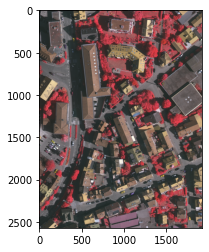

In [4]:
import numpy as np
from skimage.io import imsave, imread
import matplotlib.pyplot as plt

# TODO: Read image
norm_image = imread("image_week3/normalized_image.tif")
# TODO: Visualize the image using matplotlib
plt.imshow(norm_image)

In [6]:
y_min = 210
x_min = 494
y_max = 351
x_max = 697
# TODO; Crop the image using the bounding box coordinates defined above
crop_arr = norm_image[y_min:y_max+1, x_min:x_max+1]

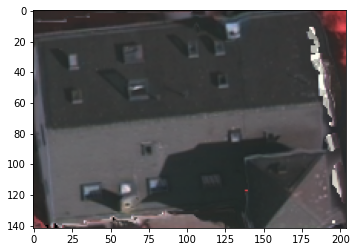

In [7]:
# TODO: Display the cropped region 
plt.imshow(crop_arr)

## 3. Implement functions to compute image features 

- Implement 3 functions to compute image features:
    - Compute the average value for each of the three bands
    - Compute the standard deviation for each of the three bands
    - Compute the histogram for each of the three bands


### Computing the average feature

In [11]:
def convert_to_shape_pixels_by_bands(data):
    num_dimensions = len(data.shape)
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[2]
        return data.reshape((-1, num_bands))
    else:
        return data


def compute_average_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # TODO: Get the number of bands
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        # TODO: compute the average value of each band (use the function np.mean)
        avg_features[b] = np.mean(data_2d[:, b])
    return avg_features

In [12]:
# TODO: Compute and print the average feature of the cropped region
avg_features_crop = compute_average_feature(crop_arr)
print(avg_features_crop)

[69.97932201 68.94780447 70.07636012]


### Compute the standard deviation feature

In [18]:
def compute_standard_deviation_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # TODO: Compute the standard deviation feature (using the numpy function np.std)
    #       as in the function compute_average_feature iterate over the bands
    #       and compute one value for each band
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        avg_features[b] = np.std(data_2d[:, b])
    return avg_features

In [17]:
# TODO: Compute and print the standard deviation feature of the cropped region
std_features_crop = compute_standard_deviation_feature(crop_arr)
print(std_features_crop)

[30.38382639 27.19202347 28.17628373]


### Compute the histogram feature

In [20]:
def compute_histogram_feature(data, num_bins=10):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    hist_features = np.zeros((num_bands, num_bins)).astype(np.float32)
    for b in range(num_bands):
        # TODO: compute the histogram for each band 
        #       use the function np.histogram(array, bins=num_bins)
        hist, boundaries = np.histogram(data_2d[:, b], bins=num_bins)
        hist_features[b, :] = hist
    # Return a 1D array containing all the values
    return hist_features.flatten()

In [21]:
# TODO: Compute and print the historgram feature of the cropped region
hist_features_crop = compute_histogram_feature(crop_arr)
print(hist_features_crop)

[1.0000e+01 6.7690e+03 1.2156e+04 5.4910e+03 3.6700e+03 2.7700e+02
 2.4500e+02 1.8400e+02 8.4000e+01 8.2000e+01 1.0000e+01 6.9480e+03
 1.2512e+04 6.6910e+03 2.1840e+03 1.9000e+02 1.6500e+02 1.3900e+02
 5.8000e+01 7.1000e+01 1.0000e+01 6.5600e+03 1.2244e+04 4.6860e+03
 4.7260e+03 2.6100e+02 1.6000e+02 1.8500e+02 6.5000e+01 7.1000e+01]


## 4. Segment the image into regions using SLIC

Use the function ***slic*** from the ***skimage*** library to segment the image into regions

In [38]:
# TODO: Segment the image into regions using SLIC
from skimage.segmentation import slic
segmented_image = slic(norm_image, n_segments=700, start_label=0)
# Compute the real number of regions 
num_regions = len(np.unique(segmented_image))
print(num_regions)

491


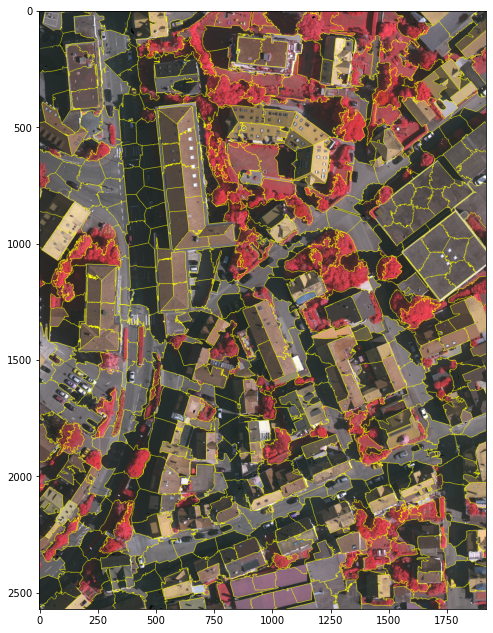

In [39]:
from skimage.segmentation import mark_boundaries
# Plot borders of regions obtained by SLIC
plt.figure(figsize = (11,11)) 
plt.imshow(mark_boundaries(norm_image, segmented_image))

## 5. Compute image features from regions

- Implement the function (below) to compute image feature from regions obtained by SLIC
- Compute the features for all the regions of the example image
- Save compute features on disk using the function ***np.save***

In [32]:
def compute_image_features_from_regions(image, segmentation_map):
    num_regions = len(np.unique(segmentation_map))
    all_features = []
    for id_region in range(num_regions):
        # Obtain pixel values of each regions, with shape (num_pixels x num_bands)
        pixel_values = image[segmentation_map==id_region]
        # TODO: compute the average, standard deviation and histogram features
        #       and concatenated them unsing the function (np.concatenate)
        avg = compute_average_feature(pixel_values)
        features = compute_standard_deviation_feature(pixel_values)
        hist_features = compute_histogram_feature(pixel_values)
        features = np.concatenate([avg, features, hist_features])
        # Add concatenated features to the variable all_features
        all_features.append(features)
    # convert list to numpy array of shape: (num_regions x num_bands)
    return np.array(all_features).astype(np.float32)

In [34]:
# TODO: Compute features for each region
features_per_region = compute_image_features_from_regions(norm_image, segmented_image)

In [35]:
# TODO: Save features using the function np.save(output_path, array)
np.save("image_week3/features.npy", features_per_region)

## 6. Answer the remaining questions of the PDF instructions file